In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'font/NanumGothic.otf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import re
import math

# Model
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, OneHotEncoder, MEstimateEncoder, OrdinalEncoder, CatBoostEncoder

import eli5
from eli5.sklearn import PermutationImportance



def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# 모든 열을 표시하도록 설정
pd.set_option('display.max_columns', None)

In [27]:
train = pd.read_csv('data/kkh_train.csv', encoding='utf-8')
test = pd.read_csv('data/kkh_test.csv', encoding='utf-8')
subway = pd.read_csv('data/subway_feature.csv', encoding='utf-8')
bus = pd.read_csv('data/bus_feature.csv', encoding='utf-8')

In [28]:
# test['구'] = test['시군구'].apply(lambda x: x.split()[1])
# test['동'] = test['시군구'].apply(lambda x: x.split()[2])

In [29]:
train['세대별주차대수'] = train['주차대수'] / train['k-전체세대수']
test['세대별주차대수'] = test['주차대수'] / test['k-전체세대수']

In [30]:
train['아파트명'].fillna(train['동'] + ' 아파트', inplace=True)

In [31]:
train['동+아파트명'] = train['동'] + ' ' + train['아파트명']
test['동+아파트명'] = test['동'] + ' ' + test['아파트명']

In [32]:
# train['계약년'] = train['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
# train['계약월'] = train['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

# test['계약년'] = test['계약년월'].astype('str').map(lambda x : x[:4]).astype('int')
# test['계약월'] = test['계약년월'].astype('str').map(lambda x : x[4:]).astype('int')

In [33]:
# 컬럼명에서 '(㎡)', 'k-', '(아파트,주상복합등등)', '(분양형태)' 삭제
def clean_column_name(name):
    name = re.sub(r'k-', '', name)
    name = re.sub(r'\(.*?\)', '', name)
    return name.strip()

# train과 test 데이터프레임의 컬럼명 정리
train.columns = [clean_column_name(col) for col in train.columns]
test.columns = [clean_column_name(col) for col in test.columns]

display(train.head(2))
display(test.head(2))

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,단지분류,전화번호,팩스번호,단지소개기존clob,세대타입,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사,시행사,사용검사일-사용승인일,연면적,주거전용면적,관리비부과면적,전용면적별세대현황,전용면적별세대현황,85㎡~135㎡이하,135㎡초과,홈페이지,등록일자,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,세대별주차대수,동+아파트명
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,8,3,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,124000,강남구,개포동,127.056859,37.476276,0.97037,개포동 개포6차우성
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.97,201712,22,4,1987,언주로 3,NaN,,-,-,아파트,025776611,025776673,NaN,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,NaN,NaN,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,NaN,직영,단일계약,직영,4858.0,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,123500,강남구,개포동,127.056859,37.476276,0.97037,개포동 개포6차우성


,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,단지분류,전화번호,팩스번호,단지소개기존clob,세대타입,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사,시행사,사용검사일-사용승인일,연면적,주거전용면적,관리비부과면적,전용면적별세대현황,전용면적별세대현황,85㎡~135㎡이하,135㎡초과,홈페이지,등록일자,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,좌표X,좌표Y,구,동,세대별주차대수,동+아파트명
0,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성,79.9700,202307,26,5,1987,언주로 3,2.023085e+07,,직거래,-,아파트,025776611,025776673,504.012071,분양,자치관리,계단식,개별난방,8.0,270.0,우성건설,모름,1987-11-21 00:00:00.0,22637.0,20204.0,22637.0,20.0,250.0,0.0,70.0,Missing,2022-11-09 20:10:43.0,2023-09-23 17:21:41.0,Missing,직영,단일계약,직영,4858.00,262.0,임의,2022-11-17 13:00:29.0,Y,N,2022-11-17 10:19:06.0,127.056859,37.476276,강남구,개포동,0.970370,개포동 개포6차우성
1,서울특별시 강남구 개포동,651-1,651.0,1.0,개포더샵트리에,108.2017,202308,15,10,2021,개포로 311,2.023085e+07,,중개거래,서울 강남구,아파트,025763999,025763998,504.012071,분양,위탁관리,계단식,지역난방,2.0,232.0,포스코,개포우성9차모델링조합,2021-12-01 00:00:00.0,44951.0,24878.0,31174.0,0.0,0.0,232.0,70.0,thesharp-trieh.hthomeservice.com/#/feeManage?_...,2022-01-05 18:02:23.0,2023-09-23 17:23:08.0,Missing,위탁,종합계약,위탁,2724.46,305.0,의무,2022-02-23 13:01:10.0,Y,N,2022-02-23 11:05:05.0,127.057257,37.484829,강남구,개포동,1.314655,개포동 개포더샵트리에


In [34]:
# '동+아파트명' 기준으로 그룹화하여 'target' 피처의 평균 가격 계산
mean_target_per_group = train.groupby('동+아파트명')['target'].mean()

# 평균 가격이 200,000 이상인 그룹을 리스트로 생성
high_price_groups = mean_target_per_group[mean_target_per_group >= 200000].index.tolist()

# train 데이터에 'top_apt' 피처 추가
train['top_apt'] = train['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

# test 데이터에 'top_apt' 피처 추가
test['top_apt'] = test['동+아파트명'].apply(lambda x: 1 if x in high_price_groups else 0).astype('category')

In [35]:
train.sample(3)

,시군구,번지,본번,부번,아파트명,전용면적,계약년월,계약일,층,건축년도,도로명,해제사유발생일,등기신청일자,거래유형,중개사소재지,단지분류,전화번호,팩스번호,단지소개기존clob,세대타입,관리방식,복도유형,난방방식,전체동수,전체세대수,건설사,시행사,사용검사일-사용승인일,연면적,주거전용면적,관리비부과면적,전용면적별세대현황,전용면적별세대현황,85㎡~135㎡이하,135㎡초과,홈페이지,등록일자,수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,단지신청일,target,구,동,좌표X,좌표Y,세대별주차대수,동+아파트명,top_apt
177154,서울특별시 서초구 양재동,16-19,16.0,19.0,남성1차현대타운,81.76,200908,14,3,2005,남부순환로356길 105,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45000,서초구,양재동,127.039503,37.480653,NaN,양재동 남성1차현대타운,0
464163,서울특별시 관악구 신림동,1702-1,1702.0,1.0,건영4,84.89,201709,12,6,1997,신림로48길 17-20,NaN,,-,-,NaN,028861223,028751962,2556.0,분양,위탁관리,계단식,개별난방,3.0,236.0,(주)건영종합건설,송파지구연예인지역주택조합,1997-05-23 00:00:00.0,28599.0,20031.0,25289.0,0.0,236.0,0.0,NaN,NaN,NaN,2024-07-11 14:11:26.0,112-80-00789-0,직영,종합계약,직영,1426.0,171.0,의무,2019-01-21 13:36:47.0,Y,N,2013-03-07 09:46:34.0,42000,관악구,신림동,126.933104,37.480387,0.724576,신림동 건영4,0
848066,서울특별시 강남구 개포동,656,656.0,0.0,시영,28.79,201304,9,1,1984,언주로 21,NaN,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40000,강남구,개포동,127.054048,37.478457,NaN,개포동 시영,0


In [36]:
selected_feature_list = ['아파트명', '전용면적', '계약년월', '층', '건축년도', '구', '동', '세대별주차대수', '도로명', '좌표X', '좌표Y', 'target', 'top_apt']
train = train[selected_feature_list]

In [37]:
print((train.isnull().mean() * 100).to_string())

아파트명        0.000000
전용면적        0.000000
계약년월        0.000000
층           0.000000
건축년도        0.000000
구           0.000000
동           0.000000
세대별주차대수    22.765286
도로명         0.000000
좌표X         0.000000
좌표Y         0.000000
target      0.000000
top_apt     0.000000


In [38]:
def impute_missing_values(df):
    # 수치형 피처와 범주형 피처 구분
    numeric_features = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(include=[object]).columns
    
    # 수치형 피처의 결측치를 평균값으로 대체
    for feature in numeric_features:
        mean_value = df[feature].mean()
        df[feature].fillna(mean_value, inplace=True)
    
    # 범주형 피처의 결측치를 'Missing'으로 대체
    for feature in categorical_features:
        df[feature].fillna('Missing', inplace=True)
    
    return df

impute_missing_values(train)

,아파트명,전용면적,계약년월,층,건축년도,구,동,세대별주차대수,도로명,좌표X,좌표Y,target,top_apt
0,개포6차우성,79.97,201712,3,1987,강남구,개포동,0.970370,언주로 3,127.056859,37.476276,124000,0
1,개포6차우성,79.97,201712,4,1987,강남구,개포동,0.970370,언주로 3,127.056859,37.476276,123500,0
2,개포6차우성,54.98,201712,5,1987,강남구,개포동,0.970370,언주로 3,127.056859,37.476276,91500,0
3,개포6차우성,79.97,201801,4,1987,강남구,개포동,0.970370,언주로 3,127.056859,37.476276,130000,0
4,개포6차우성,79.97,201801,2,1987,강남구,개포동,0.970370,언주로 3,127.056859,37.476276,117000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118628,갈현현대,59.94,200707,11,1998,은평구,구산동,1.000000,서오릉로21길 36,126.905543,37.612989,20000,0
1118629,갈현현대,59.94,200708,10,1998,은평구,구산동,1.000000,서오릉로21길 36,126.905543,37.612989,20000,0
1118630,갈현현대,84.83,200708,20,1998,은평구,구산동,1.000000,서오릉로21길 36,126.905543,37.612989,28000,0
1118631,갈현현대,84.83,200709,8,1998,은평구,구산동,1.000000,서오릉로21길 36,126.905543,37.612989,29000,0


In [39]:
train.isnull().sum()

아파트명       0
전용면적       0
계약년월       0
층          0
건축년도       0
구          0
동          0
세대별주차대수    0
도로명        0
좌표X        0
좌표Y        0
target     0
top_apt    0
dtype: int64

In [40]:
# eda_kkh(train)

In [41]:
# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# CAT_COLS 계산: NUMERIC_COLS를 제외한 나머지 컬럼 리스트
CAT_COLS = [col for col in train.columns if col not in NUMERIC_COLS + [TARGET]]

print(f'Target         --> {TARGET}')
print(f'Numeric Cols   --> {NUMERIC_COLS}')
print(f'Categoric Cols --> {CAT_COLS}')

Target         --> target
Numeric Cols   --> ['전용면적', '계약년월', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y']
Categoric Cols --> ['아파트명', '구', '동', '도로명', 'top_apt']


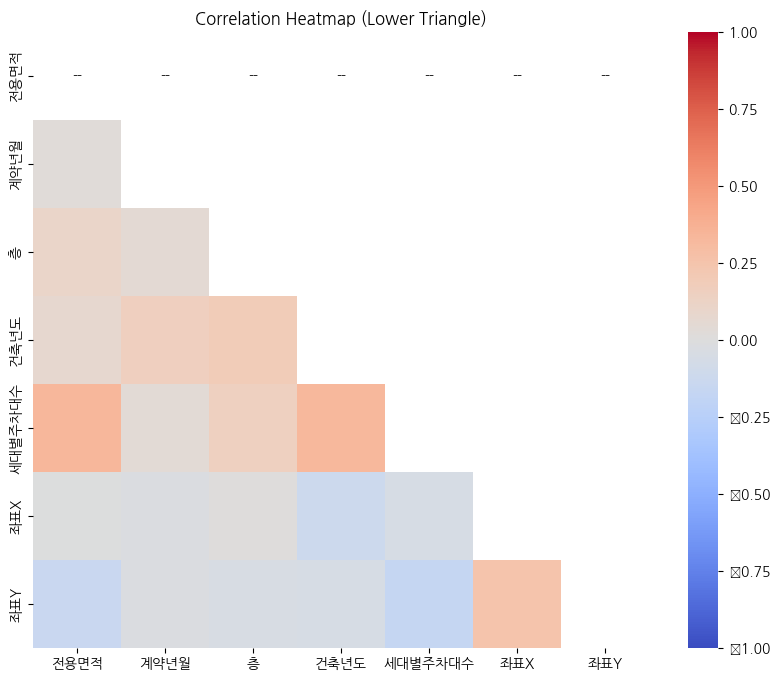

In [42]:
# TARGET 정의
TARGET = 'target'

# NUMERIC_COLS 계산: TARGET을 제외한 수치형 컬럼 리스트
NUMERIC_COLS = [col for col in train.select_dtypes(include=[float, int]).columns if col != TARGET]

# 상관관계 행렬 계산
corr_matrix = train[NUMERIC_COLS].corr()

# 하삼각형 상관관계 차트 그리기
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # 상삼각형 마스크

# 히트맵 그리기
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',  # 소수점 둘째 자리까지 표시
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    annot_kws={'size': 10, 'weight': 'bold', 'color': 'black'}  # 글자 크기, 두께, 색상
)
plt.title('Correlation Heatmap (Lower Triangle)')
plt.show()

In [43]:
# # FEATURE와 TARGET 정의
# TARGET = 'target'
# FEATURES = [col for col in train.columns if col != TARGET]

# # 범주형 피처를 수치형으로 변환하기
# categorical_features = train.select_dtypes(include=['object']).columns
# le = LabelEncoder()
# for feature in categorical_features:
#     train[feature] = le.fit_transform(train[feature])

# # 데이터 준비
# X = train[FEATURES]
# y = train[TARGET]

# # 데이터 분리 (훈련 및 테스트)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# # 랜덤 포레스트 모델 학습
# model = RandomForestRegressor(random_state=SEED)
# model.fit(X_train, y_train)

# # 피처 중요도 추출
# importances = model.feature_importances_
# importance_df = pd.DataFrame({'Feature': FEATURES, 'Importance': importances})

# # 중요도 기준으로 정렬
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # 바 차트 그리기
# plt.figure(figsize=(14, 4))
# sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
# plt.title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.show()

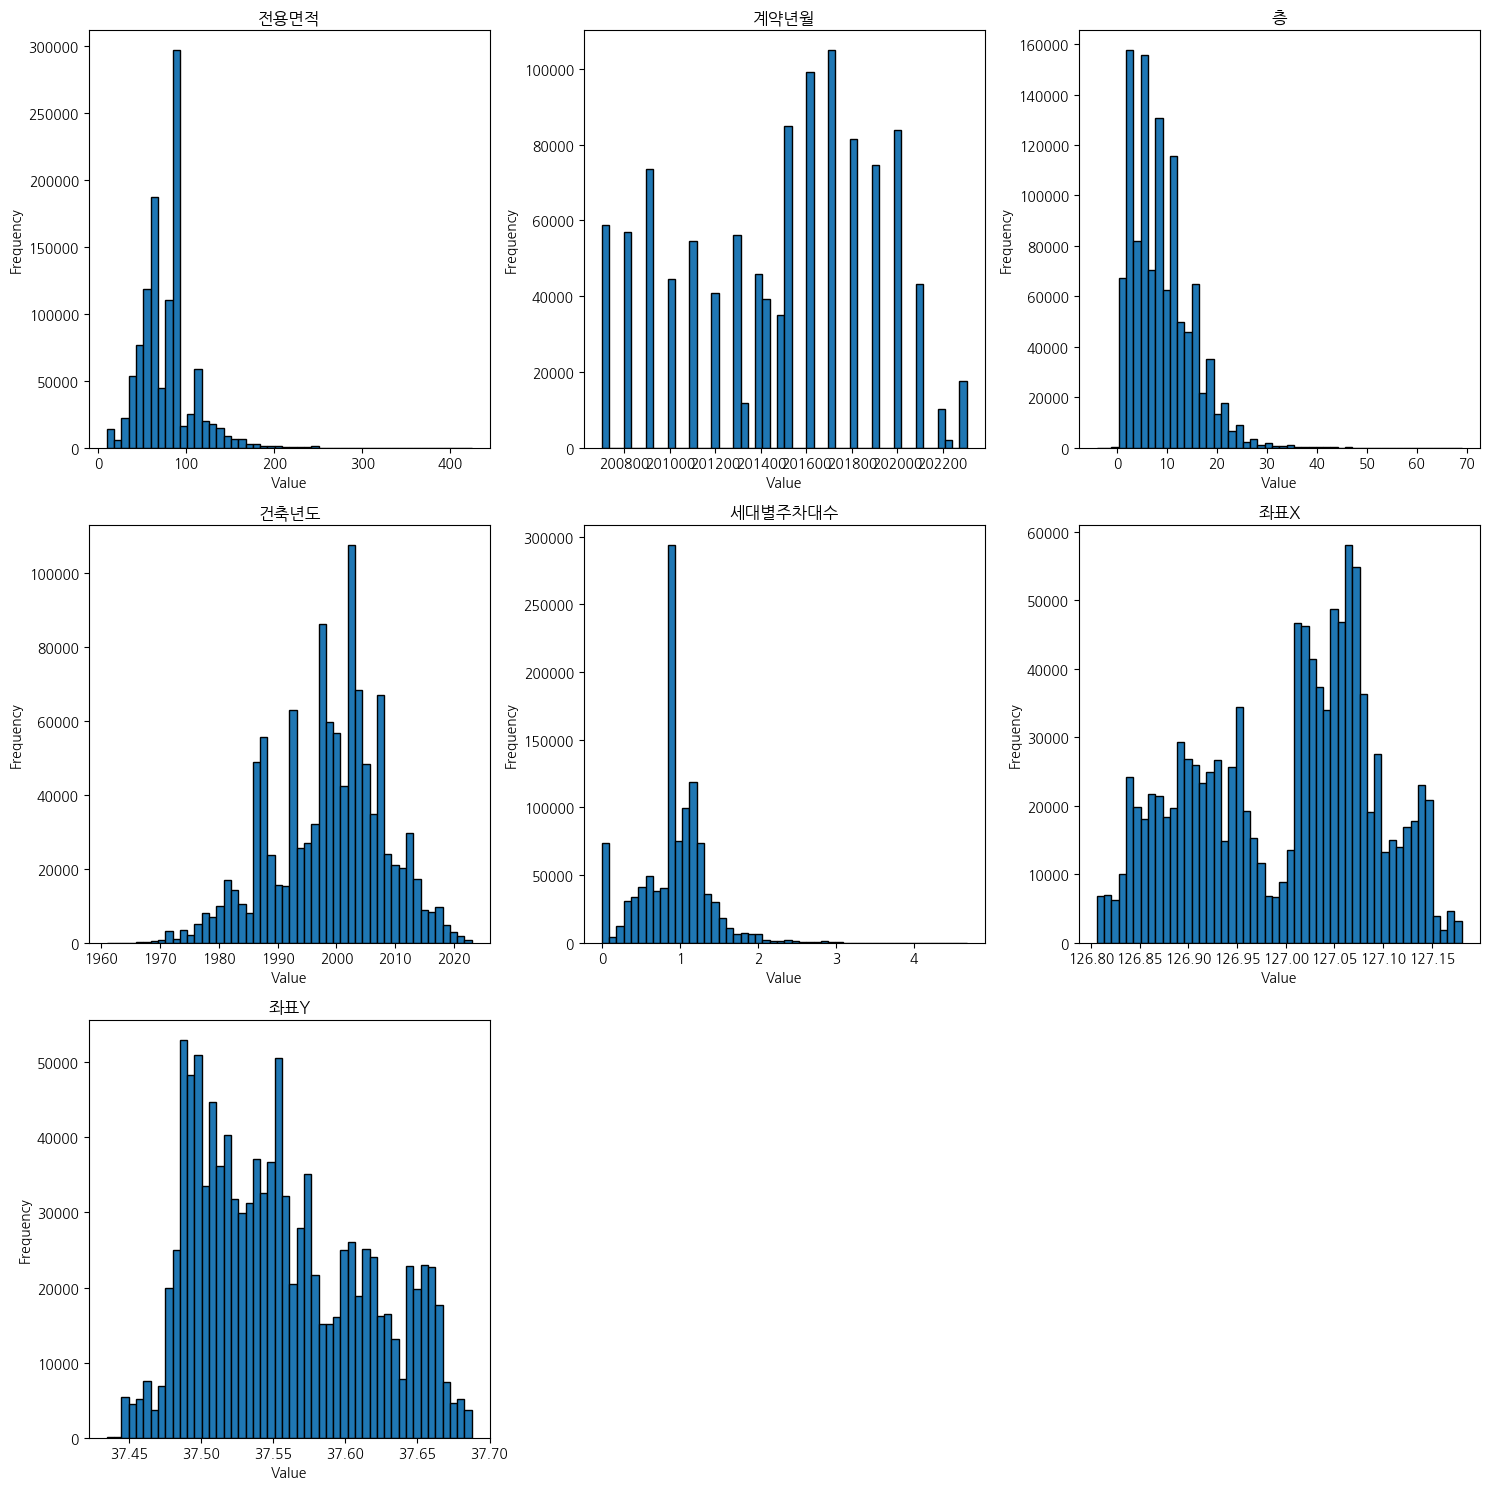

In [44]:
import matplotlib.pyplot as plt

# 데이터 준비: 수치형 데이터만 추출합니다.
numeric_data = train[NUMERIC_COLS]

# 서브플롯 개수
num_features = len(NUMERIC_COLS)
num_cols = 3  # 서브플롯 열 개수
num_rows = (num_features + num_cols - 1) // num_cols  # 필요한 행 개수 계산

plt.figure(figsize=(15, 5 * num_rows))

# 각 수치형 피처에 대해 서브플롯 생성
for i, col in enumerate(NUMERIC_COLS):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(numeric_data[col].dropna(), bins=50, edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# 레이아웃 조정
plt.tight_layout()

# 차트 표시
plt.show()


In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, CatBoost
from optuna import create_study
from optuna.integration import OptunaSearchCV
from optuna.samplers import TPESampler
import optuna

# 데이터 준비
SEED = 1053682552
NUMERIC_COLS = ['전용면적', '계약년월', '층', '건축년도', '세대별주차대수', '좌표X', '좌표Y']
CAT_COLS = ['아파트명', '구', '동', '도로명', 'top_apt']
X = train.drop(columns=['target'])
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# 전처리 및 모델 파이프라인 설정
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERIC_COLS),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_COLS)
    ])

# 옵티마이저를 위한 하이퍼파라미터 공간 설정
def objective_xgb(trial):
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 300, 800),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        alpha=trial.suggest_loguniform('alpha', 1e-4, 1e2),
        random_state=SEED
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def objective_lgb(trial):
    model = LGBMRegressor(
        n_estimators=trial.suggest_int('n_estimators', 300, 800),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        num_leaves=trial.suggest_int('num_leaves', 31, 255),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        random_state=SEED
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred)

def objective_cat(trial):
    model = CatBoostRegressor(
        iterations=trial.suggest_int('iterations', 300, 800),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        depth=trial.suggest_int('depth', 3, 6),
        random_state=SEED,
        verbose=0
    )
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# 옵티마이저 설정 및 최적화
def optimize_model(objective_function, n_trials):
    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=SEED))
    study.optimize(objective_function, n_trials=n_trials)
    return study.best_params


# 각 모델의 하이퍼파라미터 최적화
n_trials = 5

print("Optimizing XGBoost...")
xgb_best_params = optimize_model(objective_xgb, n_trials)
print("XGBoost best params:", xgb_best_params)

# print("Optimizing LightGBM...")
# lgb_best_params = optimize_model(objective_lgb, n_trials)
# print("LightGBM best params:", lgb_best_params)

print("Optimizing CatBoost...")
cat_best_params = optimize_model(objective_cat, n_trials)
print("CatBoost best params:", cat_best_params)

# 모델 정의, 학습, 예측, 평가
results = {}
for model_name, model_class, best_params in [
    ('XGBoost', XGBRegressor, xgb_best_params),
    # ('LightGBM', LGBMRegressor, lgb_best_params),
    ('CatBoost', CatBoostRegressor, cat_best_params)
]:
    model = model_class(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'R2 Score': r2, 'RMSE': rmse}

# 결과 출력
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"  R2 Score: {metrics['R2 Score']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")


[I 2024-07-17 07:35:03,229] A new study created in memory with name: no-name-af027f42-041d-4835-abea-bf1dadde78df


Optimizing XGBoost...


[I 2024-07-17 07:35:24,118] Trial 0 finished with value: 1646977410.4079723 and parameters: {'n_estimators': 677, 'learning_rate': 0.0003798782534911095, 'max_depth': 4, 'alpha': 0.31588310039776357}. Best is trial 0 with value: 1646977410.4079723.
[I 2024-07-17 07:35:55,890] Trial 1 finished with value: 122890105.09758471 and parameters: {'n_estimators': 793, 'learning_rate': 0.01306671165805956, 'max_depth': 6, 'alpha': 0.5057309506977974}. Best is trial 1 with value: 122890105.09758471.
[I 2024-07-17 07:36:13,119] Trial 2 finished with value: 1124411837.0414705 and parameters: {'n_estimators': 748, 'learning_rate': 0.0011874581171232713, 'max_depth': 3, 'alpha': 1.9997495547370978}. Best is trial 1 with value: 122890105.09758471.
[I 2024-07-17 07:36:25,247] Trial 3 finished with value: 118920081.09388685 and parameters: {'n_estimators': 379, 'learning_rate': 0.07672948312461544, 'max_depth': 5, 'alpha': 0.0005019860496167036}. Best is trial 3 with value: 118920081.09388685.
[I 2024-

XGBoost best params: {'n_estimators': 379, 'learning_rate': 0.07672948312461544, 'max_depth': 5, 'alpha': 0.0005019860496167036}
Optimizing CatBoost...


[I 2024-07-17 07:37:28,349] Trial 0 finished with value: 1671070177.213229 and parameters: {'iterations': 677, 'learning_rate': 0.0003798782534911095, 'depth': 4}. Best is trial 0 with value: 1671070177.213229.
[I 2024-07-17 07:38:15,379] Trial 1 finished with value: 118636365.4877286 and parameters: {'iterations': 592, 'learning_rate': 0.09048308290706156, 'depth': 5}. Best is trial 1 with value: 118636365.4877286.
[I 2024-07-17 07:39:19,958] Trial 2 finished with value: 249223661.48028606 and parameters: {'iterations': 695, 'learning_rate': 0.007111476293272711, 'depth': 6}. Best is trial 1 with value: 118636365.4877286.
[I 2024-07-17 07:39:58,342] Trial 3 finished with value: 2037965803.2386246 and parameters: {'iterations': 479, 'learning_rate': 0.0001029942855626323, 'depth': 5}. Best is trial 1 with value: 118636365.4877286.
[I 2024-07-17 07:40:30,674] Trial 4 finished with value: 146238480.326422 and parameters: {'iterations': 379, 'learning_rate': 0.07672948312461544, 'depth': 

CatBoost best params: {'iterations': 592, 'learning_rate': 0.09048308290706156, 'depth': 5}
0:	learn: 43898.7669743	total: 70.7ms	remaining: 41.8s
1:	learn: 41685.0952079	total: 141ms	remaining: 41.6s
2:	learn: 39633.6484222	total: 209ms	remaining: 41.1s
3:	learn: 37843.0072197	total: 277ms	remaining: 40.8s
4:	learn: 36252.1319400	total: 354ms	remaining: 41.5s
5:	learn: 34816.7401962	total: 418ms	remaining: 40.9s
6:	learn: 33460.3672309	total: 486ms	remaining: 40.6s
7:	learn: 32307.7501986	total: 555ms	remaining: 40.5s
8:	learn: 31191.9428828	total: 619ms	remaining: 40.1s
9:	learn: 30195.5391242	total: 692ms	remaining: 40.3s
10:	learn: 29336.6269694	total: 760ms	remaining: 40.1s
11:	learn: 28508.8919114	total: 821ms	remaining: 39.7s
12:	learn: 27682.9151131	total: 892ms	remaining: 39.7s
13:	learn: 26960.3455702	total: 959ms	remaining: 39.6s
14:	learn: 26317.9892284	total: 1.03s	remaining: 39.6s
15:	learn: 25731.1105559	total: 1.1s	remaining: 39.6s
16:	learn: 25184.7126681	total: 1.17s	

In [47]:
selected_feature_list = ['아파트명', '전용면적', '계약년월', '층', '건축년도', '구', '동', '세대별주차대수', '도로명', '좌표X', '좌표Y', 'top_apt']
test = test[selected_feature_list]

In [48]:
print((test.isnull().mean() * 100).to_string())

아파트명       0.0
전용면적       0.0
계약년월       0.0
층          0.0
건축년도       0.0
구          0.0
동          0.0
세대별주차대수    0.0
도로명        0.0
좌표X        0.0
좌표Y        0.0
top_apt    0.0


In [49]:
from catboost import CatBoostRegressor, CatBoost

# 로그 출력을 억제하기 위한 설정
import logging
logging.getLogger('xgboost').setLevel(logging.ERROR)
CatBoost._log_level = 'Silent'  # CatBoost의 로그 억제 설정

# 최종 모델 정의 및 학습
def train_and_predict(model_class, best_params):
    model = model_class(**best_params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X, y)
    predictions = pipeline.predict(test)
    return predictions.astype(int)  # 예측값을 int로 변환

# 예측 및 저장
print("Predicting using XGBoost...")
xgb_predictions = train_and_predict(XGBRegressor, xgb_best_params)
submission_xgb = pd.DataFrame({
    'target': xgb_predictions
})
submission_xgb.to_csv('test_xgb_10905.0484.csv', index=False)

# print("Predicting using LightGBM...")
# lgb_predictions = train_and_predict(LGBMRegressor, lgb_best_params)
# submission_lgb = pd.DataFrame({
#     'target': lgb_predictions
# })
# submission_lgb.to_csv('test_lgb.csv', index=False)

print("Predicting using CatBoost...")
cat_predictions = train_and_predict(CatBoostRegressor, cat_best_params)
submission_cat = pd.DataFrame({
    'target': cat_predictions
})
submission_cat.to_csv('test_cat_10856.1142.csv', index=False)

Predicting using XGBoost...
Predicting using CatBoost...
0:	learn: 43915.6635506	total: 92.3ms	remaining: 54.6s
1:	learn: 41656.6102882	total: 185ms	remaining: 54.4s
2:	learn: 39656.3698796	total: 271ms	remaining: 53.2s
3:	learn: 37859.8232334	total: 361ms	remaining: 53.1s
4:	learn: 36237.8739551	total: 457ms	remaining: 53.6s
5:	learn: 34812.2504800	total: 550ms	remaining: 53.7s
6:	learn: 33469.0524424	total: 644ms	remaining: 53.8s
7:	learn: 32311.4320387	total: 736ms	remaining: 53.8s
8:	learn: 31260.8746175	total: 828ms	remaining: 53.6s
9:	learn: 30212.2866099	total: 923ms	remaining: 53.7s
10:	learn: 29352.2083529	total: 1.01s	remaining: 53.7s
11:	learn: 28539.5650288	total: 1.11s	remaining: 53.8s
12:	learn: 27749.2548160	total: 1.21s	remaining: 54s
13:	learn: 27034.7460971	total: 1.3s	remaining: 53.7s
14:	learn: 26353.6958596	total: 1.39s	remaining: 53.4s
15:	learn: 25723.2542397	total: 1.48s	remaining: 53.3s
16:	learn: 25192.1778022	total: 1.58s	remaining: 53.4s
17:	learn: 24669.229